In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv('/content/ETH_day.csv')

In [23]:
# Conexión con Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Mostrar las primeras filas y la información básica del dataset
print(df.head())
print(df.info())

# Verificar nombres reales de columnas
print("Columnas actuales:", df.columns.tolist())
# Limpiar espacios
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '')
print("Columnas después de limpieza:", df.columns.tolist())
# Forzar minúsculas
df.columns = df.columns.str.lower()
print("Columnas en minúsculas:", df.columns.tolist())
# Renombrar columnas
df = df.rename(columns={
    'volumeeth': 'volume_eth',
    'volumeusd': 'volume_usd'
})
# Acceder al índice como serie temporal
print("Rango temporal:", df.index.min(), "a", df.index.max())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         date  symbol    open    high     low   close  volume eth  volume usd  \
0  2020-04-15  ETHUSD  158.61  158.61  158.61  158.61        0.00        0.00   
1  2020-04-14  ETHUSD  156.97  162.15  155.74  158.61    18061.58  2872210.44   
2  2020-04-13  ETHUSD  158.56  159.51  150.12  156.97    15698.32  2416728.28   
3  2020-04-12  ETHUSD  158.66  165.37  155.21  158.56    12877.33  2082804.05   
4  2020-04-11  ETHUSD  158.26  161.49  154.25  158.66    13761.72  2172914.57   

    returns  volatility  
0       NaN         NaN  
1  0.000000         NaN  
2 -0.010340         NaN  
3  0.010129         NaN  
4  0.000631         NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1438 non-null   object

Tipo del índice: <class 'pandas.core.indexes.range.RangeIndex'>


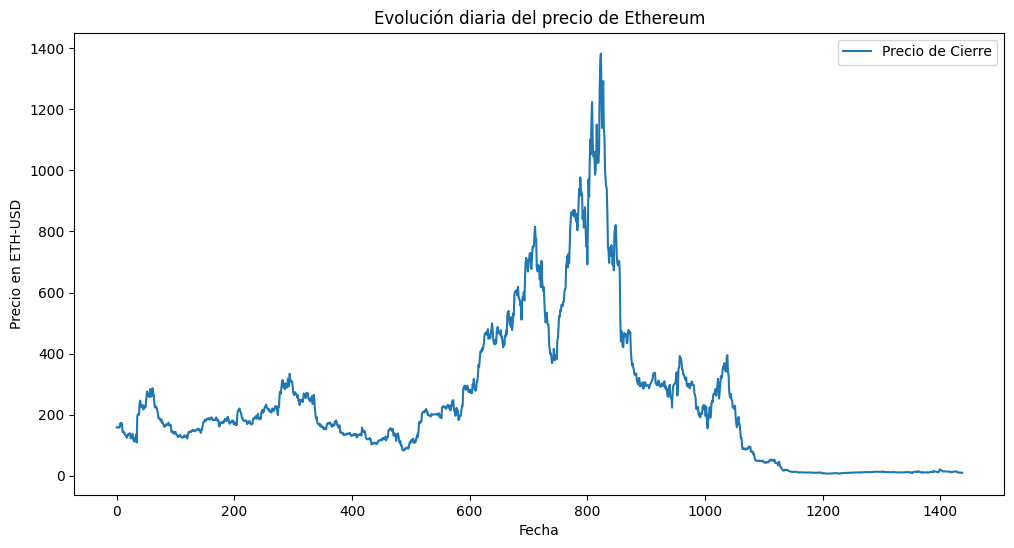

In [27]:
# Verificar el index
print("Tipo del índice:", type(df.index))

# Visualización
plt.figure(figsize=(12,6))
plt.plot(df.index, df['close'], label='Precio de Cierre')  # Usar minúscula 'close'
plt.xlabel('Fecha')
plt.ylabel('Precio en ETH-USD')
plt.title('Evolución diaria del precio de Ethereum')
plt.legend()
plt.show()

# Renombrar columnas
df = df.rename(columns={
    'volumeeth': 'volume_eth',
    'volumeusd': 'volume_usd'
})

In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

# 1. Verificación y preparación de datos
df = df.sort_index(ascending=True)

# 2. Normalización (evitar data leakage)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['close']])

# 3. Función para creación de secuencias
def create_sequences(data, window_size, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon])
    return np.array(X), np.array(y)

# 4. Hiperparámetros
WINDOW_SIZE = 60  # Capturar más historia (2 meses)
FORECAST_HORIZON = 1  # Predecir 1 día adelante

# 5. Creación de secuencias
X, y = create_sequences(scaled_data, WINDOW_SIZE, FORECAST_HORIZON)

# 6. División temporal de datos
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# 7. Reformateo para LSTM (muestras, pasos temporales, características)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Forma final de los datos:")
print(f"Entrenamiento: X{X_train.shape} y{y_train.shape}")
print(f"Validación: X{X_val.shape} y{y_val.shape}")
print(f"Test: X{X_test.shape} y{y_test.shape}")

Forma final de los datos:
Entrenamiento: X(1102, 60, 1) y(1102, 1, 1)
Validación: X(137, 60, 1) y(137, 1, 1)
Test: X(139, 60, 1) y(139, 1, 1)


In [67]:
from tensorflow.keras.layers import Layer, LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow as tf

# Split temporal (evita look-ahead bias)
def temporal_train_test_split(X, y, test_size=0.15):
    split_idx = int(len(X) * (1 - test_size))
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

# Implementación del mecanismo de atención
class TemporalAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, features)
        hidden_states = inputs

        # Calcula scores de atención
        score = self.V(tf.nn.tanh(
            self.W1(hidden_states) + self.W2(hidden_states)
        ))

        attention_weights = tf.nn.softmax(score, axis=1)

        # Aplica los pesos de atención
        context_vector = attention_weights * hidden_states

        return context_vector  # Mantenemos la dimensión temporal

# Modelo
def create_enhanced_model(input_shape):
    model = tf.keras.Sequential()

    # Capa Bidireccional
    model.add(Bidirectional(
        LSTM(128, return_sequences=True),
        input_shape=input_shape
    ))
    model.add(LayerNormalization())
    model.add(Dropout(0.3))

    # Atención Temporal
    model.add(TemporalAttention(64))
    model.add(Dropout(0.2))

    # LSTM Final
    model.add(LSTM(96, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.25))

    # Capas Densas
    model.add(Dense(32, activation='swish'))
    model.add(Dense(1))

    # Optimizador Adam
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        amsgrad=True
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsoluteError()
        ]
    )

    return model, history
#Verificando
print("Funciones de pérdida disponibles:",
      [func for func in dir(tf.keras.losses) if func.endswith('Loss') or func == 'Huber'])

Funciones de pérdida disponibles: ['Huber', 'Loss']


In [61]:
#Verificación de Dimensiones

print(f"X_train shape: {X_train.shape}")  # Debe ser (muestras, 60, 4)
print(f"y_train shape: {y_train.shape}")  # Debe ser (muestras, 1)

X_train shape: (944, 60, 4)
y_train shape: (944, 1)


In [66]:
# 1. Crear modelo
model, _ = create_enhanced_model((WINDOW_SIZE, 4))  # Input shape: (60, 4)
model.summary()

# 2. Entrenamiento con datos multidimensionales
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, mode='min'),
        ModelCheckpoint('best_multifeature_model.h5', save_best_only=True)
    ],
    verbose=1
)



# 3. Verificación final de dimensiones
print("\nVerificación dimensional:")
print(f"X_train shape: {X_train.shape} → (muestras, window_size, features)")
print(f"y_train shape: {y_train.shape} → (muestras, horizonte_predicción)")
print(f"Input del modelo: {model.input_shape} → (batch_size, 60, 4)")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_18                │ (None, 60, 256)        │       136,192 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_14          │ (None, 60, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention_14           │ (None, 60, 256)        │        32,961 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 96)             │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,354 (1.18 MB)

 Trainable params: 308,354 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2977 - mean_absolute_error: 0.1286 - root_mean_squared_error: 0.1828

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.2931 - mean_absolute_error: 0.1234 - root_mean_squared_error: 0.1767 - val_loss: 0.1968 - val_mean_absolute_error: 0.0786 - val_root_mean_squared_error: 0.0826
Epoch 2/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1764 - mean_absolute_error: 0.0458 - root_mean_squared_error: 0.0642

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1739 - mean_absolute_error: 0.0453 - root_mean_squared_error: 0.0636 - val_loss: 0.1179 - val_mean_absolute_error: 0.0743 - val_root_mean_squared_error: 0.0764
Epoch 3/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1051 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0543

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1026 - mean_absolute_error: 0.0368 - root_mean_squared_error: 0.0544 - val_loss: 0.0687 - val_mean_absolute_error: 0.0763 - val_root_mean_squared_error: 0.0786
Epoch 4/100
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0607 - mean_absolute_error: 0.0346 - root_mean_squared_error: 0.0522

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0587 - mean_absolute_error: 0.0340 - root_mean_squared_error: 0.0514 - val_loss: 0.0398 - val_mean_absolute_error: 0.0815 - val_root_mean_squared_error: 0.0835
Epoch 5/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0337 - mean_absolute_error: 0.0346 - root_mean_squared_error: 0.0503

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0328 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0498 - val_loss: 0.0230 - val_mean_absolute_error: 0.0785 - val_root_mean_squared_error: 0.0812
Epoch 6/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0189 - mean_absolute_error: 0.0346 - root_mean_squared_error: 0.0516

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0184 - mean_absolute_error: 0.0345 - root_mean_squared_error: 0.0514 - val_loss: 0.0132 - val_mean_absolute_error: 0.0681 - val_root_mean_squared_error: 0.0720
Epoch 7/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0106 - mean_absolute_error: 0.0311 - root_mean_squared_error: 0.0483

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0103 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0478 - val_loss: 0.0082 - val_mean_absolute_error: 0.0656 - val_root_mean_squared_error: 0.0701
Epoch 8/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0060 - mean_absolute_error: 0.0271 - root_mean_squared_error: 0.0415

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0059 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0413 - val_loss: 0.0055 - val_mean_absolute_error: 0.0644 - val_root_mean_squared_error: 0.0680
Epoch 9/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0036 - mean_absolute_error: 0.0251 - root_mean_squared_error: 0.0384

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0036 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0382 - val_loss: 0.0040 - val_mean_absolute_error: 0.0609 - val_root_mean_squared_error: 0.0647
Epoch 10/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0328

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0022 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0334 - val_loss: 0.0031 - val_mean_absolute_error: 0.0582 - val_root_mean_squared_error: 0.0626
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0016 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0326

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0016 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0326 - val_loss: 0.0028 - val_mean_absolute_error: 0.0596 - val_root_mean_squared_error: 0.0634
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0348 - val_loss: 0.0030 - val_mean_absolute_error: 0.0670 - val_root_mean_squared_error: 0.0690
Epoch 13/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0413

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014 - mean_absolute_error: 0.0270 - root_mean_squared_error: 0.0404 - val_loss: 0.0027 - val_mean_absolute_error: 0.0630 - val_root_mean_squared_error: 0.0667
Epoch 14/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - mean_absolute_error: 0.0230 - root_mean_squared_error: 0.0356

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0360 - val_loss: 0.0024 - val_mean_absolute_error: 0.0583 - val_root_mean_squared_error: 0.0625
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.9281e-04 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0320 - val_loss: 0.0026 - val_mean_absolute_error: 0.0630 - val_root_mean_squared_error: 0.0672
Epoch 16/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0381 - val_loss: 0.0030 - val_mean_absolute_error: 0.0680 - val_root_mean_squared_error: 0.0731
Epoch 17/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0381 - val_loss: 0.0030 - val_mean_absolute_error: 0.0693 - val_root_mean_squared_error: 0.0732
Epoch 18/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.6217e-04 - mean_absolute_error: 0.0231 - root_mean_squ

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.2354e-04 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0290 - val_loss: 0.0023 - val_mean_absolute_error: 0.0616 - val_root_mean_squared_error: 0.0657
Epoch 23/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.6952e-04 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0308

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5409e-04 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0303 - val_loss: 0.0022 - val_mean_absolute_error: 0.0599 - val_root_mean_squared_error: 0.0641
Epoch 24/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.8745e-04 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0287 - val_loss: 0.0024 - val_mean_absolute_error: 0.0631 - val_root_mean_squared_error: 0.0669
Epoch 25/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.8710e-04 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0322 - val_loss: 0.0025 - val_mean_absolute_error: 0.0662 - val_root_mean_squared_error: 0.0690
Epoch 26/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.9563e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0328 - val_loss: 0.0026 - val_mean_absolute_error: 0.0669 - val_root_mean_squared_error: 0.0698
Epoch 27/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.5902e-04 - mean_absolute_error: 0.0241 - r

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.9301e-04 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0263 - val_loss: 0.0020 - val_mean_absolute_error: 0.0554 - val_root_mean_squared_error: 0.0608
Epoch 39/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.7310e-04 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0296 - val_loss: 0.0028 - val_mean_absolute_error: 0.0696 - val_root_mean_squared_error: 0.0733
Epoch 40/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.5598e-04 - mean_absolute_error: 0.0206 - root_mean_squared_error: 0.0321 - val_loss: 0.0023 - val_mean_absolute_error: 0.0597 - val_root_mean_squared_error: 0.0658
Epoch 41/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.8498e-04 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0326 - val_loss: 0.0032 - val_mean_absolute_error: 0.0719 - val_root_mean_squared_error: 0.0776
Epoch 42/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.1195e-04 - mean_absolute_error: 0.0229 - r

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.4659e-04 - mean_absolute_error: 0.0191 - root_mean_squared_error: 0.0314 - val_loss: 0.0019 - val_mean_absolute_error: 0.0537 - val_root_mean_squared_error: 0.0587
Epoch 44/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.3499e-04 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0277 - val_loss: 0.0020 - val_mean_absolute_error: 0.0564 - val_root_mean_squared_error: 0.0611
Epoch 45/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3439e-04 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0281 - val_loss: 0.0023 - val_mean_absolute_error: 0.0611 - val_root_mean_squared_error: 0.0660
Epoch 46/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.8474e-04 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0264 - val_loss: 0.0019 - val_mean_absolute_error: 0.0551 - val_root_mean_squared_error: 0.0601
Epoch 47/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3613e-04 - mean_absolute_error: 0.0172 - r

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.6507e-04 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0256 - val_loss: 0.0015 - val_mean_absolute_error: 0.0476 - val_root_mean_squared_error: 0.0522
Epoch 52/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.7127e-04 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0261 - val_loss: 0.0020 - val_mean_absolute_error: 0.0580 - val_root_mean_squared_error: 0.0619
Epoch 53/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.7370e-04 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0263 - val_loss: 0.0020 - val_mean_absolute_error: 0.0584 - val_root_mean_squared_error: 0.0621
Epoch 54/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.6736e-04 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0224 - val_loss: 0.0019 - val_mean_absolute_error: 0.0566 - val_root_mean_squared_error: 0.0602
Epoch 55/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.4895e-04 - mean_absolute_error: 0.0160 - r

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.6632e-04 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0225 - val_loss: 0.0012 - val_mean_absolute_error: 0.0434 - val_root_mean_squared_error: 0.0457
Epoch 57/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.0586e-04 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0244 - val_loss: 0.0014 - val_mean_absolute_error: 0.0477 - val_root_mean_squared_error: 0.0505
Epoch 58/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.6929e-04 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0266 - val_loss: 0.0012 - val_mean_absolute_error: 0.0440 - val_root_mean_squared_error: 0.0470
Epoch 59/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.9018e-04 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0276 - val_loss: 0.0018 - val_mean_absolute_error: 0.0534 - val_root_mean_squared_error: 0.0575
Epoch 60/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.6525e-04 - mean_absolute_error: 0.0189 - r

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7297e-04 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0268 - val_loss: 9.4606e-04 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0408
Epoch 71/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.1404e-04 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0243 - val_loss: 0.0028 - val_mean_absolute_error: 0.0699 - val_root_mean_squared_error: 0.0725
Epoch 72/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.3969e-04 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0318 - val_loss: 0.0020 - val_mean_absolute_error: 0.0592 - val_root_mean_squared_error: 0.0617
Epoch 73/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.4450e-04 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0254 - val_loss: 0.0028 - val_mean_absolute_error: 0.0692 - val_root_mean_squared_error: 0.0733
Epoch 74/100
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.2040e-04 - mean_absolute_error: 0.0160

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.1414e-04 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0240 - val_loss: 6.5345e-04 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0328
Epoch 75/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.1531e-04 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0245 - val_loss: 7.5239e-04 - val_mean_absolute_error: 0.0338 - val_root_mean_squared_error: 0.0359
Epoch 76/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.1201e-04 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - val_loss: 0.0010 - val_mean_absolute_error: 0.0414 - val_root_mean_squared_error: 0.0433
Epoch 77/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.0347e-04 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0244 - val_loss: 0.0018 - val_mean_absolute_error: 0.0556 - val_root_mean_squared_error: 0.0577
Epoch 78/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.8513e-04 - mean_absolute_error: 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.8716e-04 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0236 - val_loss: 6.4039e-04 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0327
Epoch 79/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.9541e-04 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0241 - val_loss: 9.3174e-04 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0408
Epoch 80/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.6185e-04 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0227 - val_loss: 0.0016 - val_mean_absolute_error: 0.0524 - val_root_mean_squared_error: 0.0547
Epoch 81/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.6883e-04 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0233 - val_loss: 0.0020 - val_mean_absolute_error: 0.0591 - val_root_mean_squared_error: 0.0619
Epoch 82/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.8796e-04 - mean_absolute_error: 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.5916e-04 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0257 - val_loss: 3.5254e-04 - val_mean_absolute_error: 0.0157 - val_root_mean_squared_error: 0.0216
Epoch 89/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.6537e-04 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0266 - val_loss: 0.0020 - val_mean_absolute_error: 0.0592 - val_root_mean_squared_error: 0.0611
Epoch 90/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.9503e-04 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0242 - val_loss: 7.9910e-04 - val_mean_absolute_error: 0.0356 - val_root_mean_squared_error: 0.0370
Epoch 91/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.0592e-04 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0282 - val_loss: 0.0011 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0446
Epoch 92/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.1414e-04 - mean_absolute_error: 0.

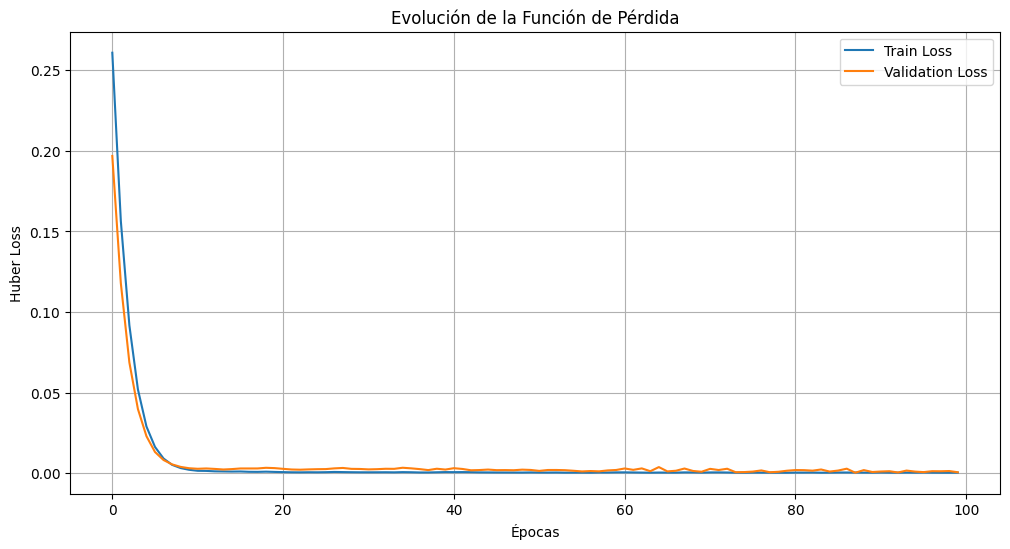

In [68]:
# Gráfico de Función de Pérdida
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución de la Función de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
def predict_future(model, last_window, scaler, n_steps=7, feature_columns=['close', 'returns', 'volatility', 'volume_usd']):
    """
    Predice los próximos 'n_steps' días usando el último window_size disponible.

    Args:
        model: Modelo entrenado
        last_window: Última ventana de datos (shape: (window_size, n_features))
        scaler: Scaler usado originalmente
        n_steps: Días a predecir
        feature_columns: Columnas usadas en el modelo

    Returns:
        Lista de predicciones en escala original
    """
    predictions = []
    current_window = last_window.copy()

    for _ in range(n_steps):
        # Predecir siguiente paso
        scaled_pred = model.predict(current_window[np.newaxis, :, :])[0, 0]

        # Inversa del scaler para obtener valor real
        dummy_data = np.zeros((1, len(feature_columns)))
        dummy_data[0, 0] = scaled_pred  # Asigna solo 'close'
        real_pred = scaler.inverse_transform(dummy_data)[0, 0]
        predictions.append(real_pred)

        # Actualizar ventana
        new_row = current_window[-1, :].copy()
        new_row[0] = scaled_pred  # Actualiza 'close'
        new_row[1] = (scaled_pred - current_window[-1, 0]) / current_window[-1, 0]  # Calcula nuevo retorno
        new_row[2] = np.std([row[1] for row in current_window[-30:]])  # Actualiza volatilidad (30 días)
        # Volume se mantiene igual al último valor conocido

        current_window = np.vstack([current_window[1:], new_row])

    return predictions

# Uso de la predicción futura
last_window_scaled = X_test[-1]  # Última ventana de test
future_predictions = predict_future(model, last_window_scaled, scaler, n_steps=7)

print("\nPredicciones próximos 7 días:")
print(pd.Series(future_predictions, name='Close Predicho'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Predicciones próximos 7 días:
0     48.351809
1    920.926364
2    916.802489
3    846.375973
4    760.672882
5    670.346484
6    581.295812
Name: Close Predicho, dtype: float64
